## PRACTICA OBLIGATORIA: **Ensembles: Bagging y Boosting**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn y modelos de ensembles
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

# Modelos Bagging y Boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menos tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

Descargamos el dataset, asignamos los nombres a las columnas

In [3]:
df = pd.read_csv(url, names=names)
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Revisamos si los datos están correctos, si hay nulos, si están desbalanceados, etc

In [4]:
# Información básica
df.info()
df.describe()
df['class'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


class
0    0.651042
1    0.348958
Name: proportion, dtype: float64

Separamos features y target y escalamos features para modelos que lo necesitan, garantizando así consistencia y evitamos que algunas variables dominen otras por su escala.

In [5]:
# Separar features y target
X = df.drop(columns=['class'])
y = df['class']

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
    )

In [6]:
# Escalado para modelos sensibles
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Definimos y preparamos los modelos de Bagging (RandomForest) y Boosting (AdaBoost y GradientBoosting), y otros potenciados como XGBoost, LightGBM y Catboost. Como sabemos, Bagging es una técnica que emplea muchos árboles independientes entrenados con submuestras, haciendo que reduzca la varianza; y Boosting emplea muchos árboles pero entrenados secuencialmente corrigiendo errores del árbol anterior. Reduciendo sesgo o bias y mejorando precisión.

In [7]:
# Bagging
rf_clf = RandomForestClassifier(random_state=42)

# Boosting
ada_clf = AdaBoostClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Opcionales: XGBoost, LightGBM, CatBoost
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_clf = LGBMClassifier(random_state=42)
cat_clf = CatBoostClassifier(random_state=42, verbose=False)

models = {
    "Random Forest": rf_clf,
    "AdaBoost": ada_clf,
    "Gradient Boosting": gb_clf,
    "XGBoost": xgb_clf,
    "LightGBM": lgb_clf,
    "CatBoost": cat_clf
}


Pasamos a usar validación cruzada para medir el rendimiento promedio de cada modelo sobre los datos de entrenamiento para evitar, así, sobreajuste al usar solo el test y nos permite comparar modelos de manera más justa antes de optimizar hiperparámetros. 

In [8]:
# Validación cruzada con Accuracy
cv_results = {}
for name, model in models.items():
    if name == "AdaBoost" or name == "Gradient Boosting":
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    else:  # RandomForest, XGBoost, etc.
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results[name] = np.mean(scores)

cv_results


h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'Random Forest': np.float64(0.7638811142209783),
 'AdaBoost': np.float64(0.750859656137545),
 'Gradient Boosting': np.float64(0.7492736238837798),
 'XGBoost': np.float64(0.7264294282287085),
 'LightGBM': np.float64(0.7345595095295214),
 'CatBoost': np.float64(0.7655204584832733)}

Tras comparar distintos modelos basados en técnicas de Bagging y Boosting mediante validación cruzada sobre el conjunto de entrenamiento, el modelo que obtiene mayor accuracy media es CatBoostClassifier, con un valor aproximado del 76.6%.

Aunque Random Forest presenta un rendimiento muy similar, CatBoost supera ligeramente al resto de modelos, por lo que se selecciona como candidato principal para su posterior optimización de hiperparámetros.

In [9]:
param_grid = {
    "depth": [4,6,8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations" : [200, 400, 600]
}

grid_cat = GridSearchCV(
    cat_clf,
    param_grid,
    cv = 5,
    scoring ='accuracy',
    n_jobs =-1
    )

grid_cat.fit(X_train_scaled, y_train)

best_cat = grid_cat.best_estimator_
grid_cat.best_params_
grid_cat.best_score_

np.float64(0.7850459816073571)

Obtenemos un 0.7850 de Accuracy media en el train optimizado, en comparación con el 0.73 en test.

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



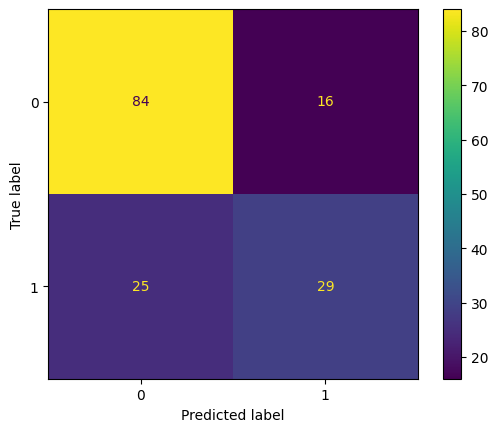

In [10]:
y_pred = best_cat.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

En la matriz podemos observar que en la clase 0 (no diabetes) hay 84 bien clasificados y 16 falsos positivos (predijo diabetes cuando no la hay), y, en la clase 1 (diabetes), observamos 29 verdaderos positivos y 25 falsos negativos (diabetes no detectada).

El dataset está desbalanceado, el modelo tiende a priorizar la clase mayoritaria y minimizar errores globales (por ello hay un buen rendimiento en clase 0 y peor en clase 1)

CatBoost optimizado alcanza una accuracy media en validación cruzada cercana al 78.5%, que desciende al 73% al evaluarse sobre el conjunto de test, lo cual es esperable al tratarse de datos no vistos durante el entrenamiento.

El modelo presenta un buen rendimiento en la clase mayoritaria, pero un recall moderado en la clase positiva, lo que indica que una parte significativa de los casos de diabetes no son detectados. Este comportamiento se explica por el desbalance del dataset y por haber optimizado el modelo usando accuracy como métrica principal.

Ya que Random Forest se ha quedado tan cerca de ser el primero, interesa analizarlo de forma optimizada.

In [11]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
grid_rf.best_params_
grid_rf.best_score_


np.float64(0.7834332933493269)

Obtenemos un rendimiento del 0.7834 cuando la accuracy media sin optimizar era del 0.7638.

Pasemos a ver el reporte de clasificación y la matriz de confusión:

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.59      0.64        54

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154



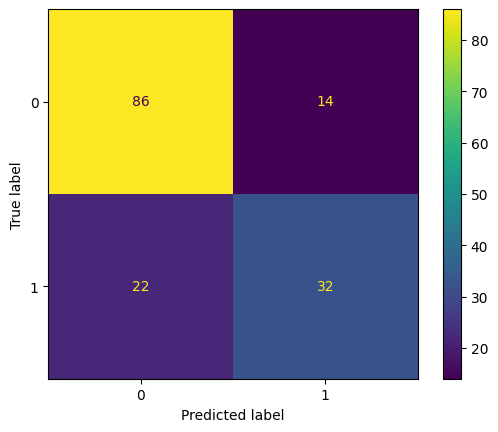

In [12]:
y_pred = best_rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


Accuracy del 0.77, mientras que CatBoost es un 0.73. Precision, Recall y F1-score, (0.7, 0.59, 0.64, respectivamente) más altos en comparación con CatBoost (0.64, 0.54 y 0.59, respectivamente).

Verdaderos positivos 32, verdaderos negativos 86, falsos negativos 22 y falsos positivos 14. 

Aunque CatBoost obtiene el mejor rendimiento medio en validación cruzada, el modelo Random Forest optimizado presenta un mejor comportamiento sobre el conjunto de test, con una mayor accuracy y una mejora clara en la detección de la clase positiva, reduciendo el número de falsos negativos.

Esto sugiere que Random Forest generaliza mejor en este problema concreto, probablemente debido a su mayor estabilidad al tratarse de un método de Bagging.